In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster, wait
import dask.array as da
import matplotlib.pyplot as plt
import cmocean
from MHW_daily_calcs import *

#### Calculate equivalent SST thresholds that applied to raw SST to see if they are smooth in time

### non-detrended case is simpler so start there

In [2]:
climyrs=[1993,2023]
qtile=0.90
smoothmethod='tri'
window=10

In [3]:
cluster = LocalCluster(n_workers=6,threads_per_worker=1,dashboard_address='localhost:54924')
client = Client(cluster)

In [4]:
flistclim = [fnameCanESMClim(workdir,climyrs[0],climyrs[-1],mm) for mm in range(1,13)]
fclim=xr.open_mfdataset(flistclim,combine='nested',concat_dim='month',parallel=True,decode_times=False)

In [5]:
method='tri'
halfwin=10

In [6]:
flclimS=[fnameCanESMClimSmooth(workdir,climyrs[0],climyrs[-1],mm, method, halfwin) for mm in range(1,13)]
fclimS=xr.open_mfdataset(flclimS,combine='nested',concat_dim='month',parallel=True,decode_times=False)

In [7]:
flistthresh=[[fnameCanESMAnomQtile(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile) for yind in [0,60,120]] for ilead in range(0,215)]
fthr=xr.open_mfdataset(flistthresh,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

In [8]:
flistthreshS=[[fnameCanESMAnomDetrQtile(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile,True,True,method,halfwin,delt=5) for yind in [0,60,120]] for ilead in range(0,215)]
fthrS=xr.open_mfdataset(flistthresh,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

In [9]:
fthr

<xarray.Dataset> Size: 1GB
Dimensions:   (leadtime: 215, month: 12, lat: 180, lon: 360)
Coordinates:
  * lat       (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * leadtime  (leadtime) float64 2kB 15.0 39.0 63.0 ... 5.127e+03 5.151e+03
  * lon       (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * month     (month) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    qt        (leadtime, month, lat, lon) float64 1GB dask.array<chunksize=(1, 12, 60, 360), meta=np.ndarray>

(0.0, 366.0)

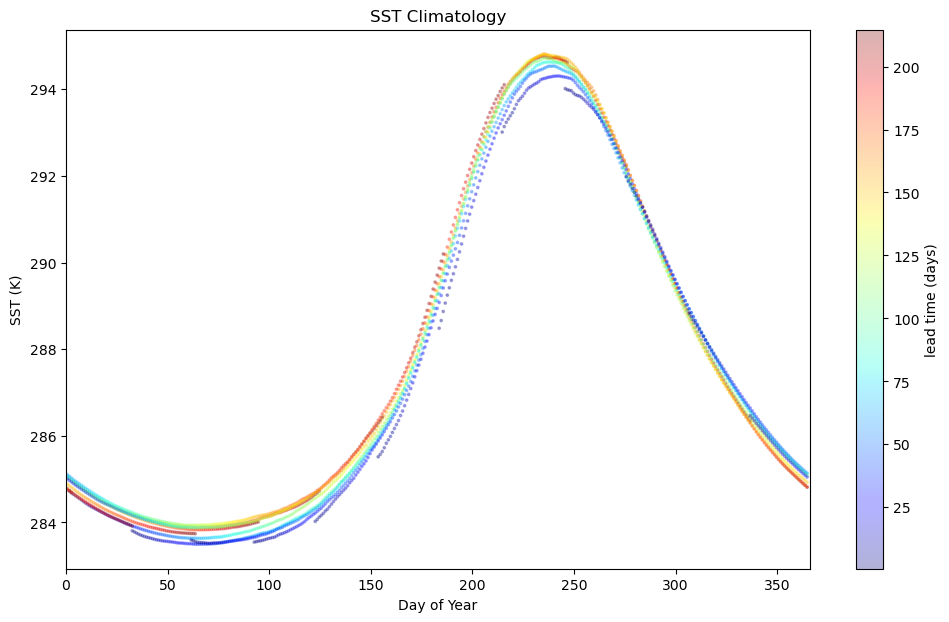

In [10]:
#clim only
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fclim.tso.isel(month=mm-1,lat=130,lon=200).values,c=fthr.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Climatology')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

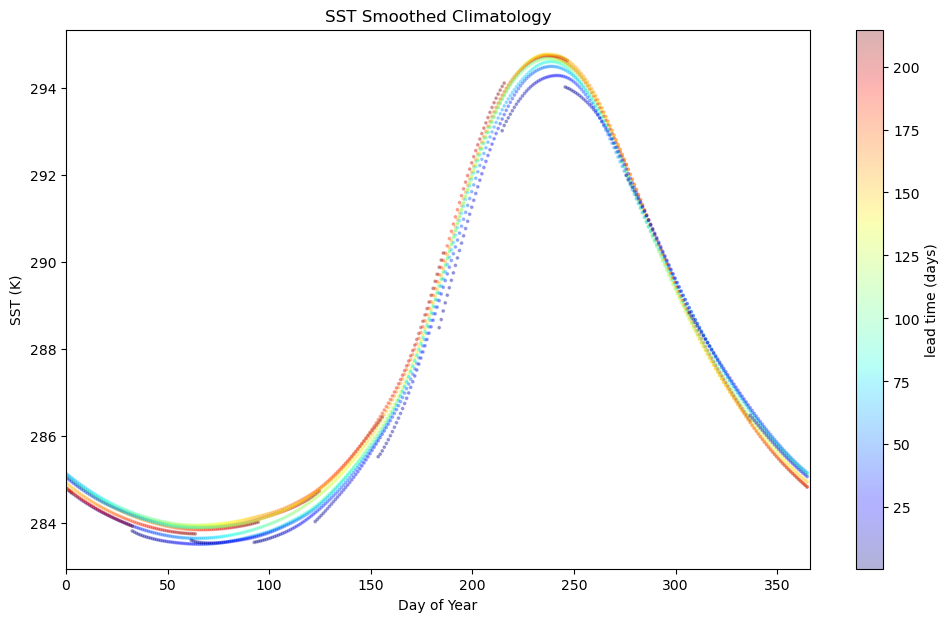

In [11]:
#clim only
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values/24
    t=t%365
    m=ax.scatter(t,fclimS.tso.isel(month=mm-1,lat=130,lon=200).values,c=fthr.leadtime.values/24,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Smoothed Climatology')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

In [12]:
fthr.close()

### now detrended version

first check trends

In [13]:
flistb=[[fnameCanESMDetrFitByLead(workdir, climyrs[0],climyrs[-1], ilead, yind) for yind in [0,60,120]] for ilead in range(0,215)]
fb=xr.open_mfdataset(flistb,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)
desstr=f'_ClimS{smoothmethod}{window}'
flistbS0=[[fnameCanESMDetrFitByLead(workdir, climyrs[0],climyrs[-1], ilead, yind,desstr) for yind in [0,60,120]] for ilead in range(0,215)]
fbS0=xr.open_mfdataset(flistbS0,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)
flistbS=[[fnameCanESMDetrFitByLeadS(workdir, climyrs[0],climyrs[-1], ilead, yind,'tri',10,desstr) for yind in [0,60,120]] for ilead in range(0,215)]
fbS=xr.open_mfdataset(flistbS,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

In [14]:
flistbS[0][0]

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/fitDetrByLead_ClimStri10_smoothedtri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_j000_ocean_1d_surface_tso.nc'

In [15]:
fb.leadtime

<xarray.DataArray 'leadtime' (leadtime: 215)> Size: 2kB
array([  0,   1,   2, ..., 212, 213, 214])
Dimensions without coordinates: leadtime

(0.0, 215.0)

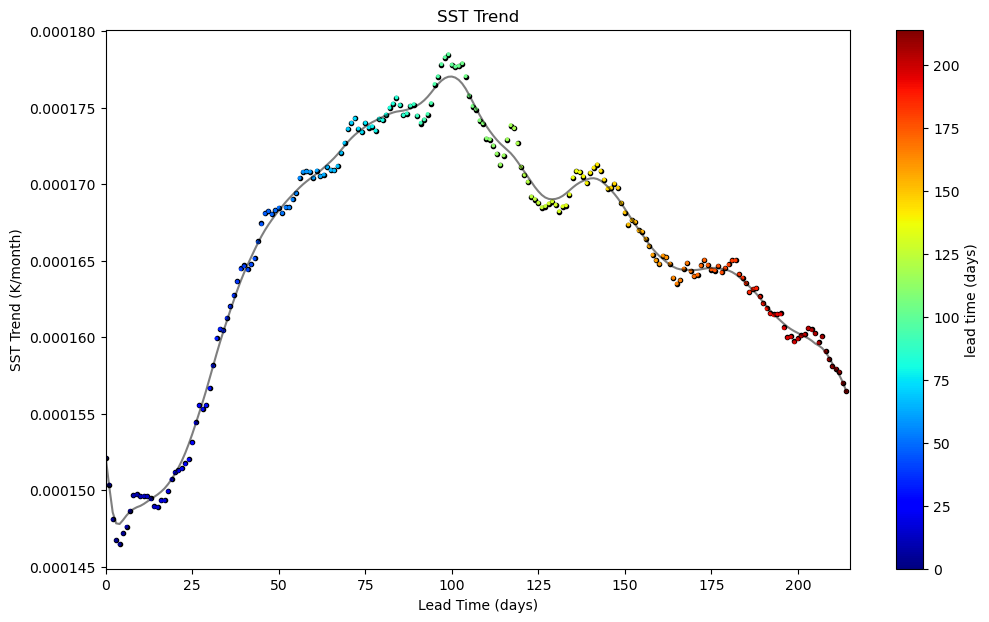

In [16]:
# trend only
fig,ax=plt.subplots(1,1,figsize=(12,7))
t=fb.leadtime.values # already in days in this file
ax.plot(t,fb.fit.isel(b=1,lat=130,lon=200),'k.',zorder=1)
m=ax.scatter(t,fbS0.fit.isel(b=1,lat=130,lon=200),c=fbS0.leadtime.values,s=3,cmap=plt.get_cmap('jet'),zorder=2)
ax.plot(t,fbS.fit.isel(b=1,lat=130,lon=200),'k-',zorder=3,alpha=.5)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Trend')
ax.set_xlabel('Lead Time (days)')
ax.set_ylabel('SST Trend (K/month)')
ax.set_xlim(0,215)

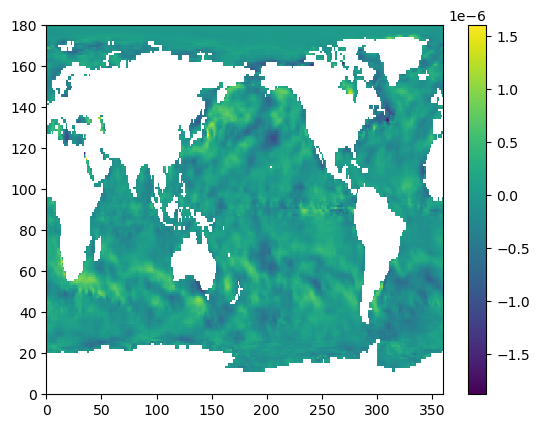

In [17]:
plt.pcolormesh(fbS.fit.isel(b=1,leadtime=1)-fb.fit.isel(b=1,leadtime=1))
plt.colorbar()

In [18]:
flistthresh

[['/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLead/qtileByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_j000_q0_90_ocean_1d_surface_tso.nc',
  '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLead/qtileByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_j060_q0_90_ocean_1d_surface_tso.nc',
  '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLead/qtileByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_j120_q0_90_ocean_1d_surface_tso.nc'],
 ['/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLead/qtileByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L001_j000_q0_90_ocean_1d_surface_tso.nc',
  '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLead/qtileByLead_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L001_j060_q0_90_ocean_1d_surface_tso.nc',
  '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLead/qtileByLead_cwao_CanESM5.1p1bc-v20

In [19]:
# detrended threshold only
flistthresh=[[fnameCanESMAnomDetrQtile(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile,False,False) for yind in [0,60,120]] for ilead in range(0,215)]
fthr=xr.open_mfdataset(flistthresh,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)
flistthreshS=[[fnameCanESMAnomDetrQtile(workdir, climyrs[0],climyrs[-1], ilead, yind, qtile,True,True,method,halfwin,delt=5) for yind in [0,60,120]] for ilead in range(0,215)]
fthrS=xr.open_mfdataset(flistthreshS,combine='nested',concat_dim=['leadtime','lat'],parallel=True,decode_times=False)

In [20]:
fthr

<xarray.Dataset> Size: 3GB
Dimensions:  (leadtime: 215, month: 12, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * month    (month) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: leadtime
Data variables:
    qt1      (leadtime, month, lat, lon) float64 1GB dask.array<chunksize=(1, 12, 60, 360), meta=np.ndarray>
    qt2      (leadtime, month, lat, lon) float64 1GB dask.array<chunksize=(1, 12, 60, 360), meta=np.ndarray>

In [21]:
fthrS

<xarray.Dataset> Size: 3GB
Dimensions:  (leadtime: 215, month: 12, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * month    (month) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
Dimensions without coordinates: leadtime
Data variables:
    qt1      (leadtime, month, lat, lon) float64 1GB dask.array<chunksize=(1, 12, 60, 360), meta=np.ndarray>
    qt2      (leadtime, month, lat, lon) float64 1GB dask.array<chunksize=(1, 12, 60, 360), meta=np.ndarray>

In [22]:
flistthreshS[0]

['/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/qtileDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_delt5_j000_q0_90_ocean_1d_surface_tso.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/qtileDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_delt5_j060_q0_90_ocean_1d_surface_tso.nc',
 '/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/qtileDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L000_delt5_j120_q0_90_ocean_1d_surface_tso.nc']

In [23]:
fnameCanESMAnomDetrQtile(workdir, climyrs[0],climyrs[-1], 5, 0, qtile,True,True,method,halfwin,delt=5)

'/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW_daily/byLeadDetr/qtileDetrByLead_ClimStri10_TrStri10_cwao_CanESM5.1p1bc-v20240611_hindcast_C1993_2023_L005_delt5_j000_q0_90_ocean_1d_surface_tso.nc'

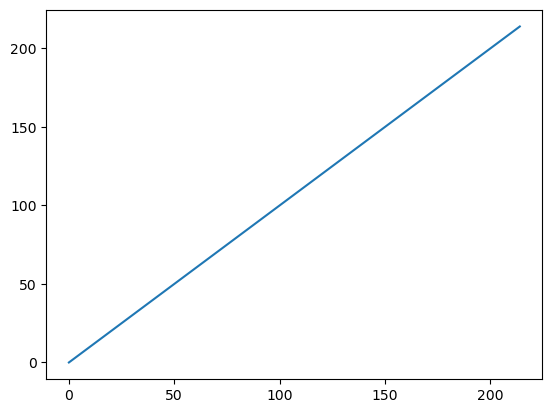

In [28]:
plt.plot(fthr.leadtime.values)

(0.0, 366.0)

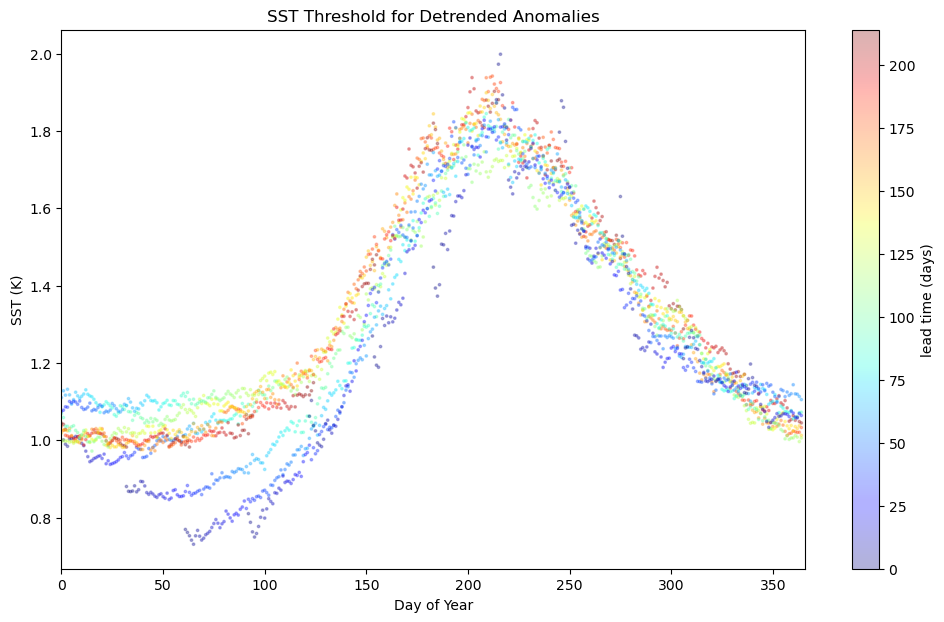

In [31]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthr.qt2.isel(month=mm-1,lat=130,lon=200),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Threshold for Detrended Anomalies: 3 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

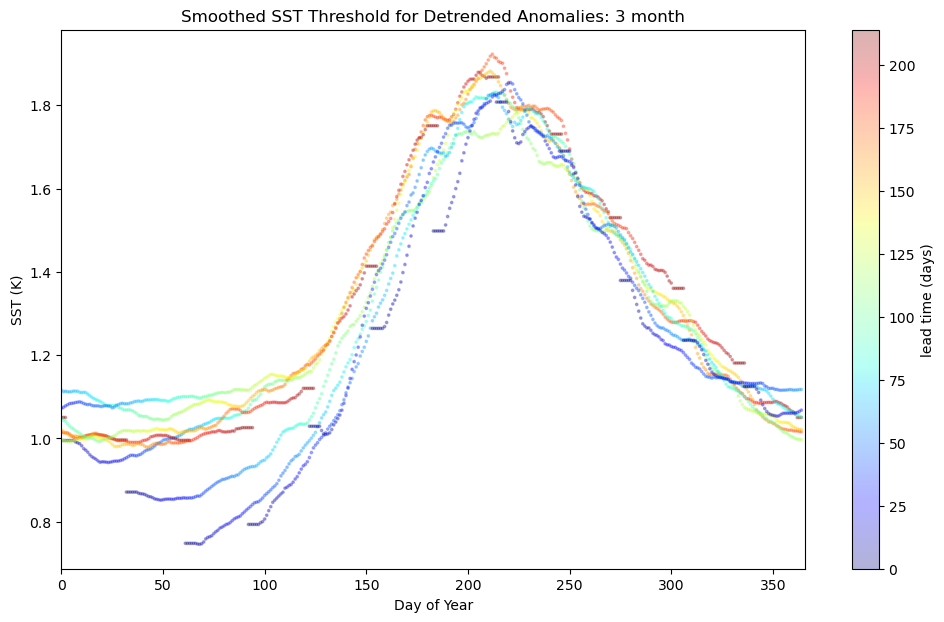

In [33]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthrS.qt2.isel(month=mm-1,lat=130,lon=200),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold for Detrended Anomalies: 3 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

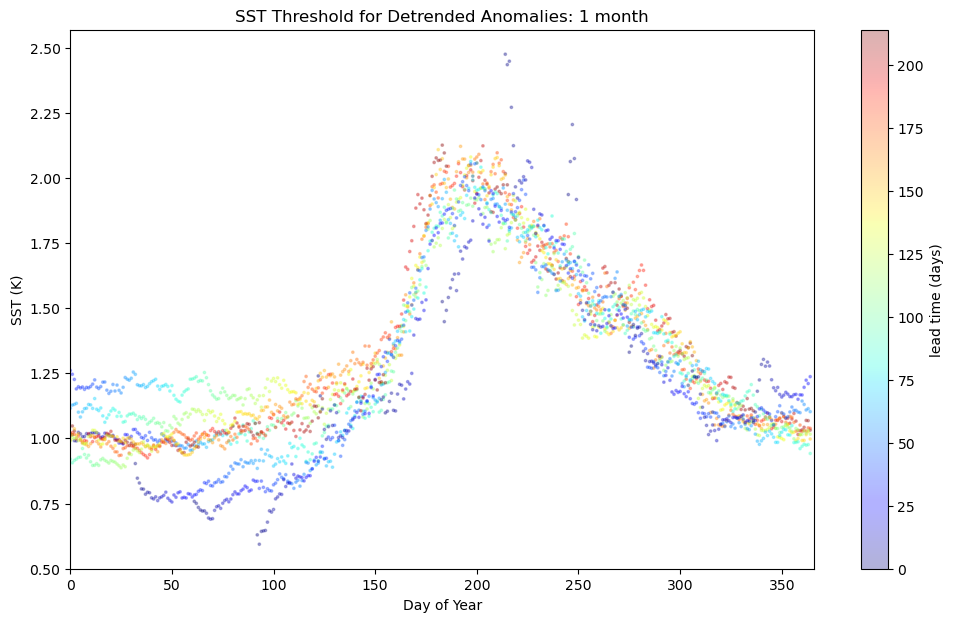

In [34]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthr.qt1.isel(month=mm-1,lat=130,lon=200),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('SST Threshold for Detrended Anomalies: 1 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

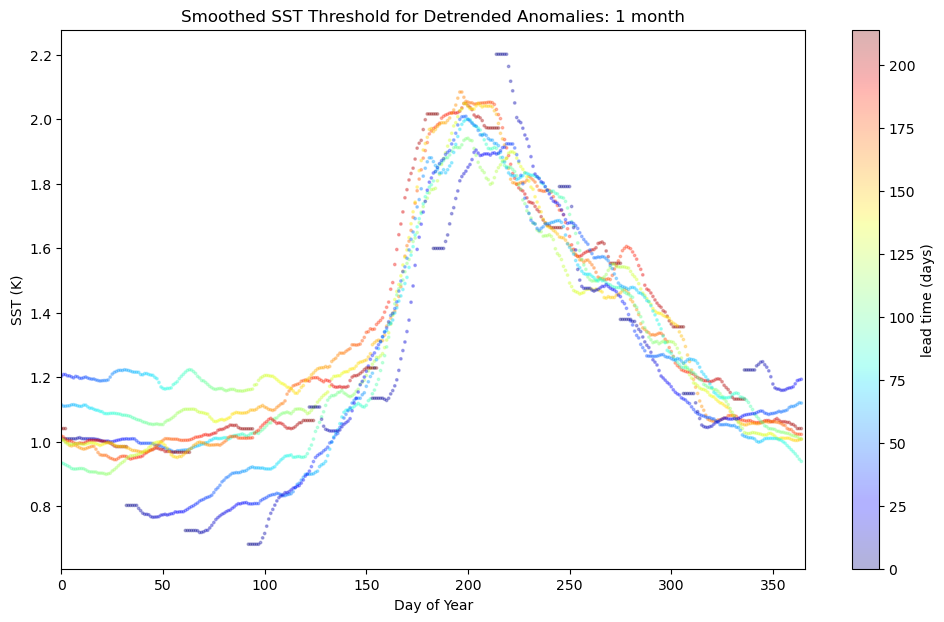

In [35]:
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fthrS.qt1.isel(month=mm-1,lat=130,lon=200),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold for Detrended Anomalies: 1 month')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

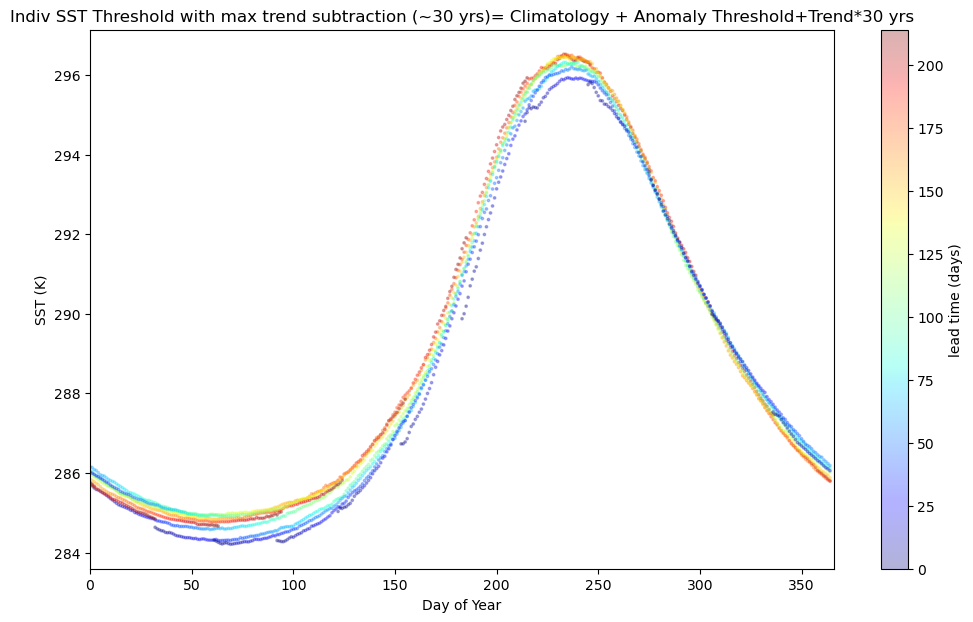

In [38]:
# ball: clim + qt + max adjustment due to trend (overestimate)
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fclim.tso.isel(month=mm-1,lat=130,lon=200).values+fthr.qt2.isel(month=mm-1,lat=130,lon=200)-\
                 fb.fit.isel(b=1,lat=130,lon=200).values*(30*12),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Indiv SST Threshold with max trend subtraction (~30 yrs)= Climatology + Anomaly Threshold+Trend*30 yrs')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(0.0, 366.0)

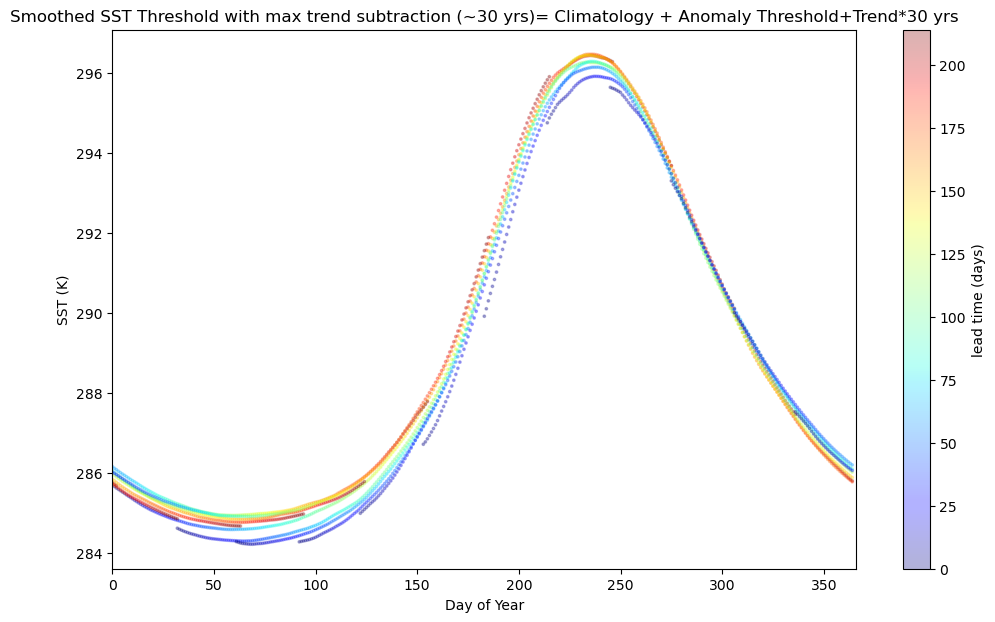

In [39]:
# ball: clim + qt + max adjustment due to trend (overestimate)
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fclimS.tso.isel(month=mm-1,lat=130,lon=200).values+fthrS.qt2.isel(month=mm-1,lat=130,lon=200)-\
                 fbS.fit.isel(b=1,lat=130,lon=200).values*(30*12),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold with max trend subtraction (~30 yrs)= Climatology + Anomaly Threshold+Trend*30 yrs')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(0,366)

(288.0, 297.0)

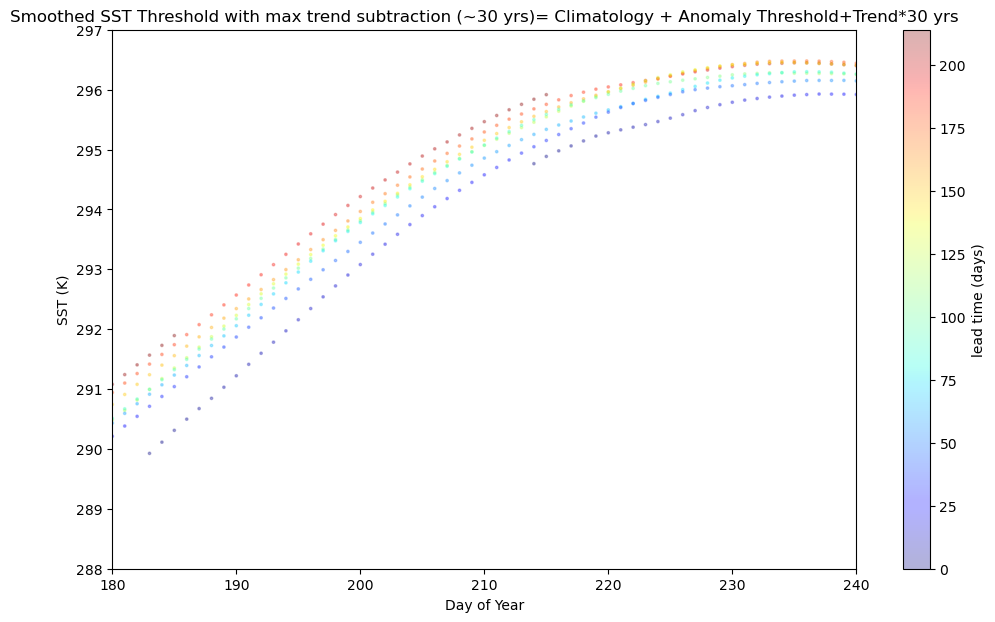

In [40]:
# ball: clim + qt + max adjustment due to trend (overestimate)
fig,ax=plt.subplots(1,1,figsize=(12,7))
for mm in range(1,13):
    t=(dt.datetime(2024,mm,1)-dt.datetime(2023,12,31)).total_seconds()/(24*3600)+fthr.leadtime.values
    t=t%365
    m=ax.scatter(t,fclimS.tso.isel(month=mm-1,lat=130,lon=200).values+fthrS.qt2.isel(month=mm-1,lat=130,lon=200)-\
                 fbS.fit.isel(b=1,lat=130,lon=200).values*(30*12),c=fthr.leadtime.values,s=3,cmap=plt.get_cmap('jet'),alpha=.3)
fig.colorbar(m,label='lead time (days)')
ax.set_title('Smoothed SST Threshold with max trend subtraction (~30 yrs)= Climatology + Anomaly Threshold+Trend*30 yrs')
ax.set_xlabel('Day of Year')
ax.set_ylabel('SST (K)')
ax.set_xlim(180,240)
ax.set_ylim(288,297)

In [41]:
fb.close(); fclim.close(); 
fthr.close()
fbS.close(); fclimS.close(); 
fthrS.close()

In [42]:
client.close()

In [43]:
cluster.close()